# Import Library

In [15]:
!pip3 install pillow
!pip3 install kaggle
!pip3 install pandas
!pip3 install matplotlib
!pip3 install torch
!pip3 install torchvision
!pip3 install scikit-learn

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
import numpy as np
import random
import torchvision.transforms as transforms
import torch.nn.functional as F

# Read Data From Kaggle

# Kaggle setup

    On your Kaggle account, under API, select "Create New API Token" and kaggle.json will be downloaded on your computer.

    Go to directory — "${user.home}\.kaggle\" — and move here the downloaded JSON file.

In [17]:
from kaggle.api.kaggle_api_extended import KaggleApi

k_api = KaggleApi()
k_api.authenticate()

In [18]:
from zipfile import ZipFile
import os
import shutil
from zipfile import ZipFile

os.makedirs('./.data/att-database-of-faces', exist_ok = True)

if not os.path.exists('./.data/att-database-of-faces.zip'):
    #downloading datasets
    k_api.dataset_download_files(
        dataset='kasikrit/att-database-of-faces',
        unzip=False
    )
    shutil.move('./att-database-of-faces.zip', './.data')

    zf = ZipFile('./.data/att-database-of-faces.zip')
    zf.extractall('./.data/att-database-of-faces/') 
    zf.close()

root_dir = './.data/att-database-of-faces'

# Problem Statement
    
    Find the top-k similar images of every image in the test set (s5, s6, s7 folders) of the AT&T dataset, using a Siamese Network with a VGG backbone. 
    
    Need to use the Triplet Loss Function. Also use Cosine Similarity to find the Top-K similar images for each image and display them.

## Prepare the dataset

In [19]:
from PIL import Image
import os
import itertools as it
import shutil

train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
os.makedirs(train_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)

for x in it.chain(range(1, 5), range(8, 41)):
   fld_path = os.path.join(root_dir, 's'+str(x))
   if os.path.exists(fld_path):
       shutil.move(fld_path, train_dir)

for x in range(5, 8):
   fld_path = os.path.join(root_dir, 's'+str(x))
   if os.path.exists(fld_path):
       shutil.move(fld_path, test_dir)

## Visualize few faces 

370 2 1


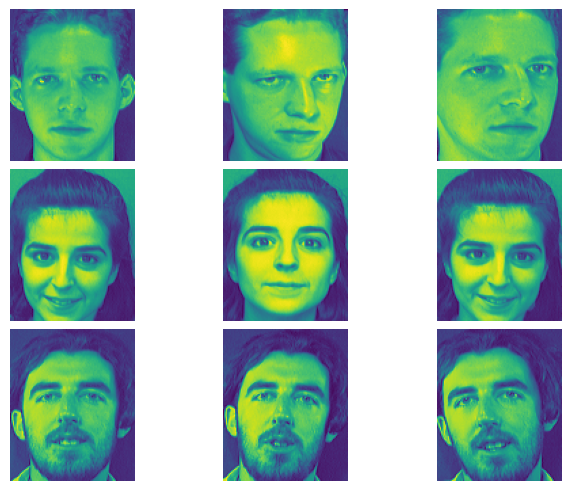

In [20]:
from torchvision.datasets import ImageFolder
from numpy.random import randint
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import itertools

sample_dataset = ImageFolder(root=train_dir)
print(len(sample_dataset), 20//10, 10//10)

num_images = 3
fig, axs = plt.subplots(num_images,num_images,
                        sharex=True,sharey=True,
                        layout='constrained')

idxs = [i for i in itertools.chain(range(0, 3), range(10, 13), range(20, 23))]
for i in range(0, num_images):
    for j in range(0, num_images):
        img = np.asarray(sample_dataset[idxs[i*num_images+j]][0].convert('L'))
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
plt.show()

## Siamese Network with VGG backbone

**Task**: The below class defines a VGG backbone for the Siamese Network where you will need to replace the last layer from the VGG model and then add a few dense layers to it along with regularization using Dropout and Batch Normalization.

In [21]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

vgg16_model = vgg16(weights=VGG16_Weights.DEFAULT)
list(vgg16_model.children())[-1]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
from torch import nn

class SiameseNetwork(nn.Module):
    def __init__(self, verbose=0):
        """
        Siamese Network with VGG-16 backbone for image similarity comparison.

        The network consists of a VGG-16 model with the last layer removed, followed by fully connected layers
        to extract features from input images. The extracted features are then used to compute image similarity.

        """
        super(SiameseNetwork, self).__init__()
        self.verbose = verbose
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        # Get the list of layers in the VGG-16 model.
        layers = list(vgg.children())
        # Remove the last layer from the list of layers.
        layers = layers[:-1]

        # Create a new model from the list of layers.
        self.backbone = nn.Sequential(*layers)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128)
        )

    def forward_once(self, x):
        """
        Perform forward pass for a single input image.

        Parameters:
            x (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output feature tensor obtained after passing through the network layers.

        """
        x = self.backbone(x)
        return self.fc(x)

    def forward(self, input1, input2, input3):
        """
        Perform forward pass for a pair of input images.

        Parameters:
            input1 (torch.Tensor): The first input image tensor.
            input2 (torch.Tensor): The second input image tensor.

        Returns:
            tuple: A tuple containing the output feature tensors obtained after passing each input image
                   through the network.

        """
        if self.verbose > 1:
            print("in forward pass", input1.shape, input2.shape, input3.shape)
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3


## Siamese Dataset

    create a dataset from the images where gets three faces, in which 2 are similar and the 3rd is dissimilar thus helping train the Siamese Network to discern the differences between the 2 images that are different and the similarity between the 2 images which are similar.

In [23]:
import numpy as np
from torch.utils.data import Dataset

# Siamese Network Dataset
class SiameseNetworkDataset(Dataset):
    """
    Custom dataset for Siamese Network training.

    This dataset randomly samples pairs of images from the given input dataset, along with their corresponding labels
    indicating whether the images belong to the same class or not. It is used for training Siamese Networks which
    learn to compare and measure similarity between two input images.

    Parameters:
        dataset (Dataset): The original (PyTorch) dataset containing images and their labels.

    """
    def __init__(self, dataset, verbose=0):
        """
        Initialize the Siamese Network dataset.

        Parameters:
            dataset (Dataset): The original (PyTorch) dataset containing images and their labels.

        """
        self.dataset = dataset
        self.labels = torch.arange(len(dataset))
        self.verbose = verbose
        self.size = len(dataset)

    def __getitem__(self, index):
        """
        Get a single sample from the Siamese Network dataset.

        Parameters:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing three images. The first element is the anchor image (img1), the second element is
                   the image which has the same label as the first image i.e. the positive image and the third element
                   is the image which has a different label than the first image i.e. the negative image.

        """
        anchor_idx = index
        anchor_min = (anchor_idx//10)*10
        anchor_max = anchor_min + 9
        
        positive_range = range(anchor_min, anchor_max)
        negative_range = np.setdiff1d(range(0, self.size), positive_range)
        
        positive_idx = np.random.choice(np.setdiff1d(positive_range, [anchor_idx]))
        negative_idx = np.random.choice(negative_range)
        
        anchor, _ = self.dataset[anchor_idx]
        positive, _ = self.dataset[positive_idx]
        negative, _ = self.dataset[negative_idx]
        
        if(self.verbose > 0):
            print(
                "(a, p, n) indices", 
                 anchor_idx, positive_idx, negative_idx)
        
        return anchor, positive, negative

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: The total number of samples in the dataset.

        """
        return len(self.dataset)

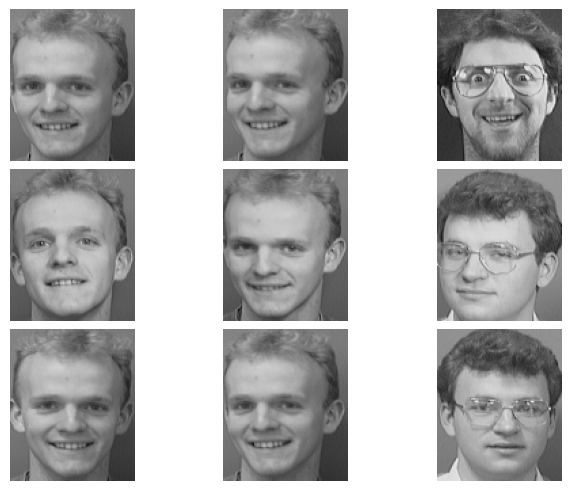

In [24]:
from torchvision.datasets import ImageFolder
from numpy.random import randint
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

sample_dataset = ImageFolder(test_dir)
sample_siamese_dataset = SiameseNetworkDataset(sample_dataset)

num_images = 3
fig, axs = plt.subplots(num_images,num_images,
                        sharex=True,sharey=True,
                        layout='constrained')

for i in range(0, num_images):
    imgset = sample_siamese_dataset[i]
    for j in range(0, num_images):
        img = imgset[j]
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
plt.show()

### Defining the Triplet Loss Function

The Triplet Loss function is a key component in training Siamese Networks and related architectures for learning similarity and dissimilarity among data points. Similar to the Contrastive Loss, the Triplet Loss aims to shape the embedding space in a way that similar samples are closer together, while dissimilar samples are pushed farther apart.

In the context of the Triplet Loss, each training sample is referred to as an "anchor." For each anchor, we identify a "positive" sample (similar to the anchor) and a "negative" sample (dissimilar to the anchor). The goal of the Triplet Loss is to ensure that the distance between the anchor and the positive sample is smaller than the distance between the anchor and the negative sample by a certain margin.

Mathematically, for an anchor sample \(A\), a positive sample \(P\), and a negative sample \(N\), the Triplet Loss is computed as:

$$L(A, P, N) = max ( | f(A) - f(P) |^2 - | f(A) - f(N) |^2 + margin, 0 )$$

Here, f(.) represents the embedding function learned by the neural network, and \(| . |\) denotes the Euclidean distance between the embedded vectors. The margin is a hyperparameter that specifies the minimum desired separation between positive and negative samples.

In summary, the Triplet Loss guides the network to learn embeddings in such a way that the positive sample is pulled closer to the anchor while the negative sample is pushed away. This encourages the network to map similar samples together in the embedding space and dissimilar samples apart, resulting in meaningful representations that capture the inherent structure of the data's similarity relationships.

In [25]:
import torch

class TripletLoss(nn.Module):
    """
    Triplet Loss function for training Siamese Networks with triplet sampling.

    The Triplet Loss encourages the model to minimize the distance between the anchor and the positive example
    while maximizing the distance between the anchor and the negative example. This helps in learning a suitable
    embedding space where similar examples are closer and dissimilar examples are farther apart.

    Parameters:
        margin (float): The margin value that defines the desired separation between positive and negative pairs.

    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin


    def forward(self, anchor, positive, negative):
        """
        Compute the Triplet Loss based on the anchor, positive, and negative examples.

        Parameters:
            anchor (torch.Tensor): Embeddings of the anchor examples.
            positive (torch.Tensor): Embeddings of the positive examples.
            negative (torch.Tensor): Embeddings of the negative examples.

        Returns:
            torch.Tensor: Computed Triplet Loss.

        """
        positive_distance = (anchor - positive).pow(2).sum(1)
        negative_distance = (anchor - negative).pow(2).sum(1)
        
        losses = torch.relu(positive_distance - negative_distance + self.margin)
        
        return losses.sum()

### Dataset and Dataloaders

In [26]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

# Setting the transformations
def lmode(img):
  return img.convert('RGB')
  
img_transform=transforms.Compose([
  transforms.Resize((100,100)),
  transforms.Lambda(lmode),
  transforms.ToTensor()
])

train_dataset = ImageFolder(train_dir, transform=img_transform)
test_dataset = ImageFolder(test_dir, transform=img_transform)
print(len(train_dataset), len(test_dataset))
print(train_dataset[10][0].shape)

370 30
torch.Size([3, 100, 100])


In [34]:
from torch.utils.data import DataLoader

# Create Siamese datasets
train_siamese_dataset = SiameseNetworkDataset(train_dataset)
test_siamese_dataset = SiameseNetworkDataset(test_dataset, verbose=0)
print(train_siamese_dataset[10][0].shape)

# Create data loaders
batch_size = 64
test_batch_size = 1
train_loader = DataLoader(train_siamese_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=True)
print("Train Dataset for Siamese Network created.", len(train_siamese_dataset))
print("Test Dataset for Siamese Network created.", len(test_siamese_dataset))

torch.Size([3, 100, 100])
Train Dataset for Siamese Network created. 370
Test Dataset for Siamese Network created. 30


### Training the Model

In [37]:
import torch

def train(model, train_data, loss_fn, optimizer):
    model.train()
    total_loss = 0.0

    for i, data in enumerate(train_data):
        (anchor, positive, negative) = data
        
        #anchor = anchor.to(device) # Move the anchor image to the device
        #positive = positive.to(device) # Move the positive image to the device
        #negative = negative.to(device) # Move the negative image to the device

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation from previous iterations
        output_anchor, output_pos, output_neg = model(anchor, positive, negative)  # Forward pass: get the output feature vectors for all three images
        loss = loss_fn(output_anchor, output_pos, output_neg) # Calculate the Contrastive Loss
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step()  # Update the model's parameters using the computed gradients

        total_loss += loss.item()
    
    return total_loss

def div_by_zero(num, den):
    if den == 0:
        return -1
    
    return num/den;
    
    
def test(model, test_data, dist_fn, threshold):
    model.eval()
    
    (TP, TN, FP, FN) = (0, 0, 0, 0)
    with torch.no_grad():
        for data in test_data:
            (anchor, positive, negative) = data
            output_anchor, output_pos, output_neg = model(anchor, positive, negative)
        
            peuclidean_distance = dist_fn(output_anchor, output_pos)
            neuclidean_distance = dist_fn(output_anchor, output_neg)
            
            # positive case
            y_pred = peuclidean_distance < threshold
            (TP, FN) = (TP+1, FN+0) if y_pred else (TP+0, FN+1)
            
            # negative case
            y_pred = neuclidean_distance < threshold
            (TN, FP) = (TN+0, FP+1) if y_pred else (TN+1, FP+0)
    
    total_tests = len(test_data)*2
    accuracy = div_by_zero((TN+TP), total_tests)
    recall = div_by_zero(TP, (TP+FN))
    precision = div_by_zero(TP, (FP+TP))
    f1 = 2 * div_by_zero(precision*recall, precision+recall)
    
    return (accuracy, precision, recall, f1)

In [38]:
import torch
from torch import optim
import torch.nn.functional as F

# Set device (GPU if available, else CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Siamese Network with VGG16 backbone
model = SiameseNetwork(verbose=0)

# Define the loss function and optimizer
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=5, verbose=True
)

# Initialize lists to track training progress
loss_history = [] # List to store the loss value during training
(accuracy_hist, precision_hist, recall_hist, f1_hist) = ([], [], [], [])

dist_fn = F.pairwise_distance
dist_threshold = 4

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = train(model, train_loader, criterion, optimizer)
    epoch_loss /= len(train_loader)
    
    (accuracy, precision, recall, f1) = test(model, test_loader, dist_fn, dist_threshold)
    
    loss_history.append(epoch_loss)
    accuracy_hist.append(accuracy*100)
    precision_hist.append(precision*100)
    recall_hist.append(recall*100)
    f1_hist.append(f1*100)
    
    torch.save(
        model.state_dict(), 
        "./.chkpts/att-database-of-faces/model-{}.pt".format(epoch))
    
    scheduler.step(epoch_loss)
    
    # Print loss and store it in the history lists every 10 iterations
    if epoch % 1 == 0 :
        print("Epoch {}: loss={}, accuracy={}, recall={}".format(epoch, round(epoch_loss, 4), round(accuracy, 2), round(recall, 2)))

total= 60 TP+FN+TN+FP= 60
Epoch 0: loss=184.6395, accuracy=0.68, recall=0.37
total= 60 TP+FN+TN+FP= 60
Epoch 1: loss=152.6039, accuracy=0.55, recall=0.13
total= 60 TP+FN+TN+FP= 60
Epoch 2: loss=136.1346, accuracy=0.68, recall=0.47
total= 60 TP+FN+TN+FP= 60
Epoch 3: loss=155.8814, accuracy=0.63, recall=0.27
total= 60 TP+FN+TN+FP= 60
Epoch 4: loss=88.5045, accuracy=0.63, recall=0.27
total= 60 TP+FN+TN+FP= 60
Epoch 5: loss=58.9994, accuracy=0.73, recall=0.5
total= 60 TP+FN+TN+FP= 60
Epoch 6: loss=97.1963, accuracy=0.87, recall=0.73
total= 60 TP+FN+TN+FP= 60
Epoch 7: loss=48.8096, accuracy=0.77, recall=0.53
total= 60 TP+FN+TN+FP= 60
Epoch 8: loss=61.6993, accuracy=0.82, recall=0.63
total= 60 TP+FN+TN+FP= 60
Epoch 9: loss=34.5205, accuracy=0.82, recall=0.67
total= 60 TP+FN+TN+FP= 60
Epoch 10: loss=26.0848, accuracy=0.75, recall=0.53
total= 60 TP+FN+TN+FP= 60
Epoch 11: loss=22.7365, accuracy=0.75, recall=0.6
total= 60 TP+FN+TN+FP= 60
Epoch 12: loss=24.6241, accuracy=0.67, recall=0.43
total= 

### Plotting the loss

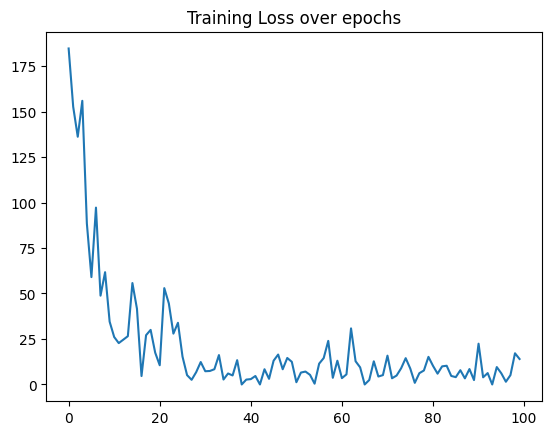

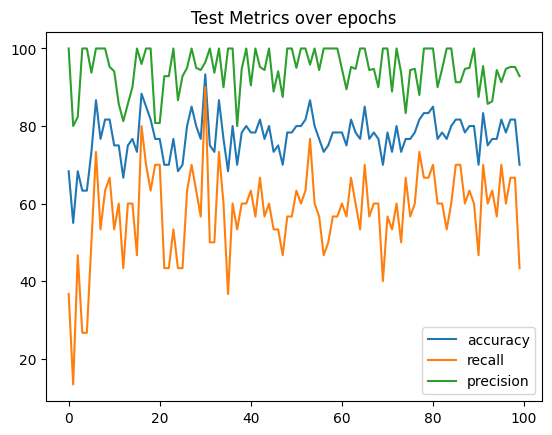

In [39]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training Loss over epochs")
plt.show()

plt.plot(accuracy_hist, label="accuracy")
plt.plot(recall_hist, label="recall")
plt.plot(precision_hist, label="precision")
plt.legend()
plt.title("Test Metrics over epochs")
plt.show()

In [50]:
import os
import shutil

best_epoch = 99
att_modelstate_root_dir = './.model-state/att-database-of-faces'
os.makedirs(att_modelstate_root_dir, exist_ok=True)
shutil.copy('./.chkpts/att-database-of-faces/model-{}.pt'.format(best_epoch), att_modelstate_root_dir)

att_modelstate_path = os.path.join(att_modelstate_root_dir, 'model-{}.pt'.format(best_epoch))

### Evaluating the Model

The Euclidean distance is a commonly used metric to quantify the similarity between two feature vectors in image analysis. It calculates the straight-line distance between the points in the feature space. Smaller distances indicate higher similarity, while larger distances indicate dissimilarity. The Euclidean distance metric is intuitive and straightforward to compute, making it widely used in various applications such as image retrieval and clustering.

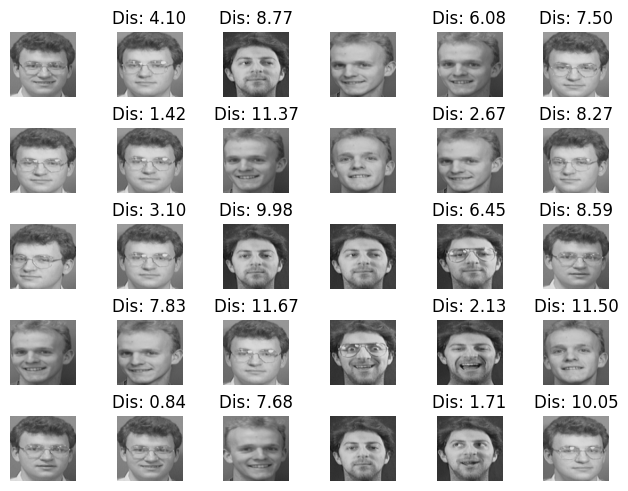

In [43]:
import torchvision
import torch
import matplotlib.pyplot as plt

import torchvision.transforms as T
from PIL import Image

import torch.nn.functional as F

att_saved_state_dict = torch.load(att_modelstate_path)
loaded_model = SiameseNetwork()
loaded_model.load_state_dict(att_saved_state_dict)

to_image = T.ToPILImage()

# Evaluation
loaded_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    dataiter = iter(test_loader)
    num_tests = 10
    fig, axs = plt.subplots(
        num_tests//2,6,
        sharex=True,sharey=True,
        layout='constrained')
    
    for i in range(num_tests):
        a,p,n = next(dataiter)
        
        #a = a.to(device)
        #p = p.to(device)
        #n = n.to(device)
        
        # Forward pass through the Siamese Network to get the output feature vectors for both images
        output1,output2,output3 = loaded_model(a, p, n)
        
        # Calculate the Euclidean distance between the output feature vectors
        peuclidean_distance = F.pairwise_distance(output1, output2)
        neuclidean_distance = F.pairwise_distance(output1, output3)
        
        # show images side by side
        col = i%2*3
        axs[i//2, col].imshow(to_image(torch.squeeze(a)))
        axs[i//2, col].axis('off')
        
        axs[i//2, col+1].imshow(to_image(torch.squeeze(p)))
        axs[i//2, col+1].axis('off')
        axs[i//2, col+1].set_title('Dis: {:.2f}'.format(peuclidean_distance.item()))
        
        axs[i//2, col+2].imshow(to_image(torch.squeeze(n)))
        axs[i//2, col+2].axis('off')
        axs[i//2, col+2].set_title('Dis: {:.2f}'.format(neuclidean_distance.item()))
        
    plt.show()

In [51]:
import torch
import torch.nn.functional as F
import pandas as pd

def testing(model, test_data, threshold):
    model.eval()
    
    predictions = []
    with torch.no_grad():
        for (anchor, positive, negative) in test_data:
            (pout1, pout2, _) = model(anchor, positive, positive)
            (nout1, nout2, _) = model(anchor, negative, negative)
            
            pdissimilarity = F.pairwise_distance(pout1, pout2)
            ndissimilarity = F.pairwise_distance(nout1, nout2)
            
            predictions.append({
                'pred': (pdissimilarity < threshold).item(), 
                'actual': True, 
                'img1': anchor,
                'img2': positive
            })
            predictions.append({
                'pred': (ndissimilarity < threshold).item(), 
                'actual': False, 
                'img1': anchor,
                'img2': negative
            })
    
    return pd.DataFrame(predictions)

Acc 0.7 Prec 1.0 Recall 0.4


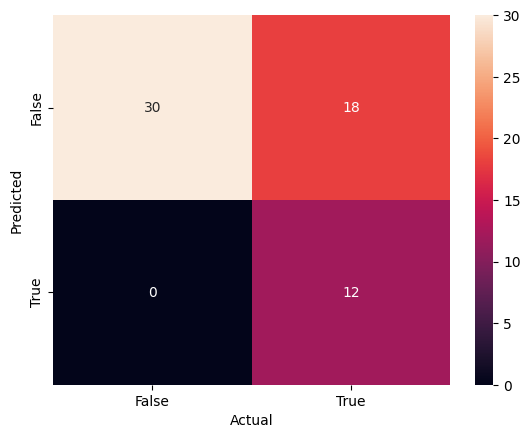

In [52]:
import pandas as pd
import seaborn as sn
import torch.nn.functional as F
import matplotlib.pyplot as plt

results = testing(loaded_model, test_loader, 3)

confusion_matrix = pd.crosstab(
    results['pred'], 
    results['actual'], 
    rownames=['Predicted'], colnames=['Actual'])

total = len(results)

TP = confusion_matrix[True][True]
TN = confusion_matrix[False][False]

FP = confusion_matrix[False][True]
FN = confusion_matrix[True][False]

accuracy = (TP+TN)/total
precision = (TP)/(TP+FP)
recall = TP/(TP+FN)

print("Acc", accuracy, "Prec", precision, "Recall", recall)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

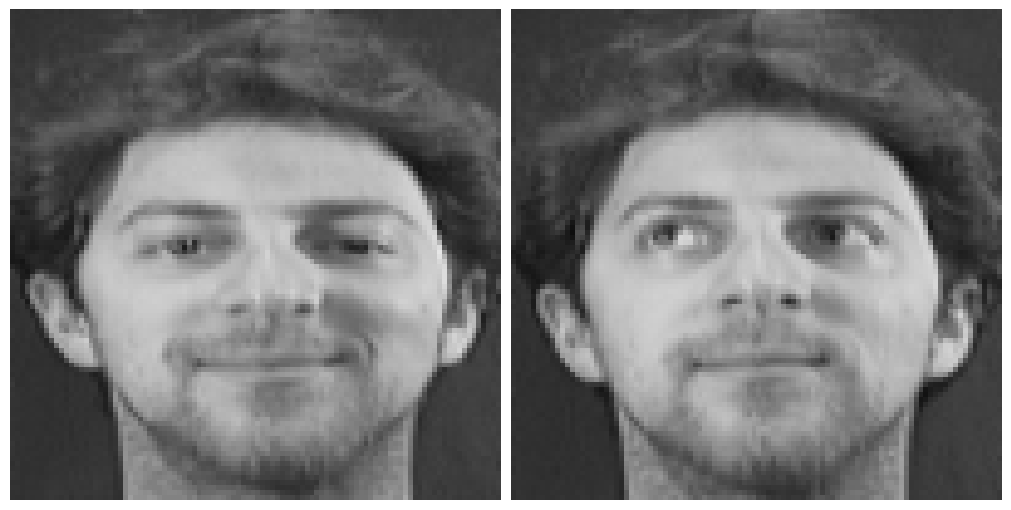

In [46]:
def show_images(df):
        num_rows = df.shape[0]
        fig, axs = plt.subplots(
                num_rows, 2,
                sharex=True,sharey=True,
                figsize=(10, 10),
                layout="constrained")

        for i in range(num_rows):
                ax = axs[i, 0] if num_rows > 1 else axs[0]
                ax.imshow(to_image(torch.squeeze(df.iloc[i]['img1'])))
                ax.axis('off')

                ax = axs[i, 1] if num_rows > 1 else axs[1]
                ax.imshow(to_image(torch.squeeze(df.iloc[i]['img2'])))
                ax.axis('off')

        plt.show()

fp_filter = (results.pred == True) & (results.actual == False)
show_images(results[fp_filter])

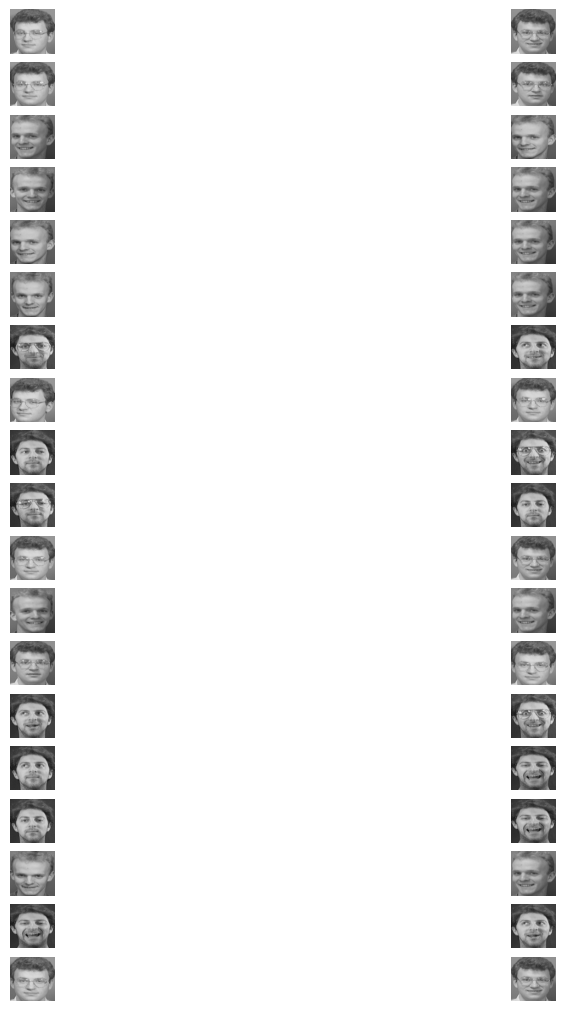

In [47]:
fn_filter = (results.pred == False) & (results.actual == True)
show_images(results[fn_filter])

Cosine Similarity is a widely employed metric for assessing the similarity between two feature vectors in image analysis and other domains. It quantifies the cosine of the angle between two vectors in the feature space. Higher cosine similarity values indicate greater alignment in direction and orientation, implying higher similarity between the vectors.

Compared to Euclidean distance, which measures the straight-line distance between points, Cosine Similarity focuses on the angle between vectors, disregarding their magnitudes. This means that even if the vectors have different lengths, they can still exhibit high cosine similarity if they are pointing in the same general direction.

Mathematically, the Cosine Similarity between two vectors \(A\) and \(B\) is computed as:

Cosine Similarity(A, B) = A . B / (|A\| * \|B\|)

Where \(A . B\) represents the dot product of the two vectors, and \(\|A\|\) and \(\|B\|\) represent the magnitudes (or lengths) of the respective vectors.

Cosine Similarity values range between -1 and 1. A Cosine Similarity of 1 indicates that the vectors are perfectly aligned and have the same orientation. A Cosine Similarity of -1 indicates that the vectors are perfectly aligned but have opposite orientations. A Cosine Similarity of 0 implies that the vectors are orthogonal, indicating no similarity in direction.

Cosine Similarity finds use in diverse applications like text analysis, recommendation systems, and image retrieval. Its ability to measure the direction of similarity while ignoring magnitude variations makes it particularly suited for scenarios where magnitude differences are not as relevant as the alignment of features.

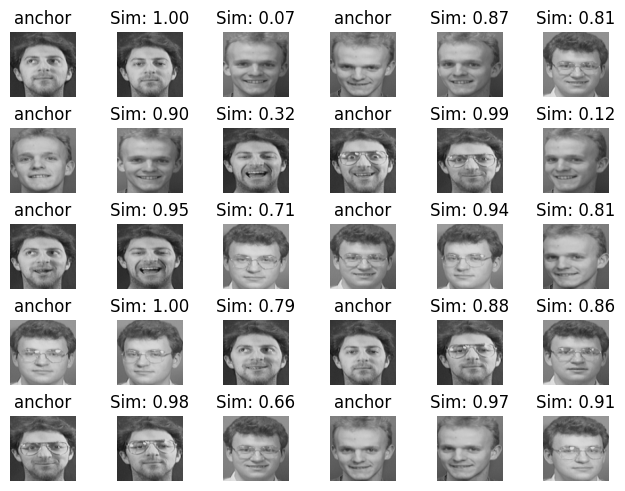

In [48]:
# Using Cosine Similarity
import torchvision
import torch
import matplotlib.pyplot as plt

cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

num_tests = 10
fig, axs = plt.subplots(
    num_tests//2, 6,
    sharex=True,sharey=True,
    layout='constrained')
    
# Evaluation
loaded_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    dataiter = iter(test_loader)
    for i in range(num_tests):
        aimg, pimg, nimg = next(dataiter)
        
        #x1 = x1.to(device)
        # Forward pass through the Siamese Network to get the output feature vectors for both images
        output1,output2,output3 = loaded_model(aimg, pimg, nimg)
        
        # Calculate the Cosine Similarity between the output feature vectors
        pcosine_similarity = cos(output1, output2)
        ncosine_similarity = cos(output1, output3)
        
        # The 'cv2_imshow' function is used to display images in the Colab environment
        col = i%2*3
        axs[i//2, col].imshow(to_image(torch.squeeze(aimg)))
        axs[i//2, col].axis('off')
        axs[i//2, col].set_title("anchor")
        
        axs[i//2, col+1].imshow(to_image(torch.squeeze(pimg)))
        axs[i//2, col+1].axis('off')
        axs[i//2, col+1].set_title('Sim: {:.2f}'.format(pcosine_similarity.item()))
        
        axs[i//2, col+2].imshow(to_image(torch.squeeze(nimg)))
        axs[i//2, col+2].axis('off')
        axs[i//2, col+2].set_title('Sim: {:.2f}'.format(ncosine_similarity.item()))

### Finding Top-5 Images

find the top-k images for all images in the test folder using cosine_similarity.

In [ ]:
# Using Cosine Similarity - Top K matches
def find_top_similar_vectors(image_vector, feature_vectors, top_n=5):
    # TODO - Write your solution here

# TODO - Write your solution here to display the top-k images for each image in the test folder